In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
from IPython.display import HTML

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

### Set Initial Parameters

In [4]:
batch_size = 1

### Create Dataset and Dataloader

In [5]:
data_dir = '/Users/alexandergao/Documents/DeepLearning/Competition/competition/data'
annotation_csv = '/Users/alexandergao/Documents/DeepLearning/Competition/competition/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [6]:
transform = torchvision.transforms.ToTensor()

# unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, first_dim='sample', transform=transform)
# trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

In [7]:
labeled_trainset = LabeledDataset(image_folder=data_dir,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
#                                   img_transform = transforms.ToTensor(),
#                                   map_transform = None,
                                  img_transform=transforms.Compose([transforms.CenterCrop(256),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=(0.5,), std=(0.5,))
                                                                   ]),
                                  map_transform=transforms.Compose([transforms.ToPILImage(),
                                                                    transforms.Resize(256),
                                                                    transforms.ToTensor()
                                                                   ]),
                                  extra_info=True
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=2, collate_fn=collate_fn)

In [8]:
labeled_trainset[1][0].size()

torch.Size([18, 256, 256])

In [9]:
for images, road_maps in trainloader:
    print(images.size())
    break

# # sample, target, road_image, extra = iter(trainloader).next()
# # print(len(sample[0]))
# # # print(torch.stack(sample).shape)
# # print(road_image[0].size())

torch.Size([1, 18, 256, 256])


In [10]:
# print(road_image[0])

In [11]:
# # The 6 images orgenized in the following order:
# # CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
# plt.imshow(torchvision.utils.make_grid(sample[4], nrow=3).numpy().transpose(1, 2, 0))
# plt.axis('off');

In [12]:
# # The road map layout is encoded into a binary array of size [800, 800] per sample 
# # Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# # The ego car is located in the center of the map (400, 400) and it is always facing the left

# fig, ax = plt.subplots()
# ax.imshow(road_image[4][0], cmap='binary');

### Define models

In [13]:
class ResnetBlock(nn.Module):
    """
    Define a Resnet block
    A resnet block is a conv block with skip connections
    Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
    """
    def __init__(self, dim):
        """
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        """
        super(ResnetBlock, self).__init__()
        self.resnet_block = nn.Sequential(nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(dim),
                                          nn.ReLU(True),
                                          nn.Dropout(0.5),
                                          nn.Conv2d(dim, dim, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(dim)
                                         )
        
    def forward(self, x):
        return x + self.resnet_block(x)  # add skip connections

In [14]:
class Generator(nn.Module):
    """
    RESNET-based generator that consists of Resnet blocks + downsampling/upsampling operations.
    """
    def __init__(self, in_ch, out_ch, ngf, n_blocks=6, init_gain=0.02):
        """
        Parameters:
            in_ch (int)         -- the number of channels in input images
            out_ch (int)        -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """        
        assert(n_blocks >= 0)
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            
            nn.Conv2d(in_ch, ngf, kernel_size=7, padding=0),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.Conv2d(ngf, ngf * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.Conv2d(ngf * 2, ngf * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            ResnetBlock(ngf * 4),  #1
            ResnetBlock(ngf * 4),  #2
            ResnetBlock(ngf * 4),  #3
            ResnetBlock(ngf * 4),  #4
            ResnetBlock(ngf * 4),  #5
            ResnetBlock(ngf * 4),  #6
            ResnetBlock(ngf * 4),  #7
            ResnetBlock(ngf * 4),  #8
            ResnetBlock(ngf * 4),  #9

            nn.ConvTranspose2d(ngf * 4, int(ngf * 2), kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(int(ngf * 2)),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, int(ngf), kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(int(ngf)),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, out_ch, kernel_size=7, padding=0),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, ndf=64, n_layers=3):  
        super(Discriminator, self).__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(in_ch, ndf, kernel_size=4, stride=2, padding=1),
                                    nn.LeakyReLU(0.2, True)
                                   )
        
        nf_mult = 1
        nf_mult_prev = 1
        sequence2 = []        
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence2 += [nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=2, padding=1),
                         nn.BatchNorm2d(ndf * nf_mult),
                         nn.LeakyReLU(0.2, True)
                        ]
        self.block2 = nn.Sequential(*sequence2)
        
        sequence3 = []
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence3 += [nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=1, padding=1),
                     nn.BatchNorm2d(ndf * nf_mult),
                     nn.LeakyReLU(0.2, True)
        ]
        self.block3 = nn.Sequential(*sequence3)
        
        self.model = nn.Sequential(self.block1,
                                   self.block2,
                                   self.block3,
                                   nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)
                                  )
        
    def forward(self, x):
        return self.model(x)

In [16]:
in_ch = 18
out_ch = 1
ngf = 64
ndf = 64
n_blocks_g = 9
n_layers_d = 3

n_epochs = 100
lr_g = 0.0002
lr_d = 0.0002
beta1 = 0.5
beta2 = 0.999

real_label = 1.0
gen_label = 0.0

In [17]:
# Sanity check - dimensions of inputs and outputs to both networks.

test = torch.zeros([1, 18, 256, 256])
print("Input to generator:\t", test.size())

test_generator = Generator(in_ch, out_ch, ngf, n_blocks=n_blocks_g, init_gain=0.02)
test_result_g = test_generator(test)
print("\nOutput of generator:\t", test_result_g.size())

test_d_input = torch.cat((test_result_g, test), 1)
print("\nInput to discriminator:\t", test_d_input.size())

test_discriminator = Discriminator(in_ch + out_ch, ndf=ndf, n_layers=n_layers_d)
test_result_d = test_discriminator(test_d_input)
print("\nOutput of discriminator:", test_result_d.size())

Input to generator:	 torch.Size([1, 18, 256, 256])

Output of generator:	 torch.Size([1, 1, 256, 256])

Input to discriminator:	 torch.Size([1, 19, 256, 256])

Output of discriminator: torch.Size([1, 1, 30, 30])


In [18]:
class GANLoss(nn.Module):
    """
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """
    def __init__(self, gan_mode, real_label=1.0, gen_label=0.0):
        """
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_gen_label (bool) - - label of a generated image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        
        self.gan_mode = gan_mode
        self.real_label = real_label
        self.gen_label = gen_label
        
        if gan_mode == 'LS':
            self.loss = nn.MSELoss()
        elif gan_mode == 'BCE':
            self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, output, target_is_real):
        # Create label tensors with same size as the discriminator output.
        if target_is_real:
            target_tensor = torch.Tensor([self.real_label])
        else:
            target_tensor = torch.Tensor([self.gen_label])
            
        return target_tensor.expand_as(output)

    def __call__(self, output, target_is_real):
        target_tensor = self.get_target_tensor(output, target_is_real)
        loss = self.loss(output, target_tensor)
        return loss

In [19]:
generator = Generator(in_ch, out_ch, ngf, n_blocks=n_blocks_g, init_gain=0.02)
discriminator = Discriminator(in_ch + out_ch, ndf=ndf, n_layers=n_layers_d)

In [20]:
# We combine GAN Loss and L1 Loss to attain Total Loss
criterion_gan = GANLoss('BCE', real_label=real_label, gen_label=gen_label).to(device)
criterion_L1 = nn.L1Loss()

optim_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, beta2))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))

### Train

In [22]:
iters = 0
update_stats_rate = 150
losses_g = []
losses_d = []
intermediate_images = []

In [ ]:
####################################
########## TRAINING LOOP ###########
####################################
for epoch in range(n_epochs):
    print("Epoch #:", epoch)
    for real_18ch, real_map in tqdm(trainloader):
        """
        TRAIN DISCRIMINATOR ON REAL AND GENERATED SAMPLES
        """
        gen_map = generator(real_18ch)
        
        real_19ch = torch.cat((real_18ch, real_map), 1).to(device)
        gen_19ch = torch.cat((real_18ch, gen_map.detach()), 1).to(device)

        output_real = discriminator(real_19ch)
        output_gen = discriminator(gen_19ch)
        
        d_real_mean = output_real.mean().item()
        d_gen_mean_pre = output_gen.mean().item()

        target_real = torch.Tensor([real_label]).expand_as(output_real).to(device)
        target_gen = torch.Tensor([gen_label]).expand_as(output_gen).to(device)

        loss_d_real = criterion_gan(output_real, target_is_real=True) + criterion_L1(output_real, target_real)
        loss_d_gen = criterion_gan(output_gen, target_is_real=False) + criterion_L1(output_gen, target_gen)
        loss_d_total = (loss_d_real + loss_d_gen)
        
        discriminator.zero_grad()
        loss_d_total.backward()
        optim_D.step()
        
        """
        TRAIN GENERATOR
        """
        output_gen = discriminator(gen_19ch)
        loss_g = criterion_gan(output_gen, target_is_real=True) + criterion_L1(output_gen, target_real)
        d_gen_mean_post = output_gen.mean().item()
        
        generator.zero_grad()
        loss_g.backward()
        optim_G.step()
        
        """
        COMPILE TRAINING STATISTICS
        """
        losses_d.append(loss_d_total)
        losses_g.append(loss_g)
        
        if iters % update_stats_rate == 0:
            print('Epoch: [%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f\td(real): %.4f \td(gen) pre/post-g-step: %.4f / %.4f'
                  % (epoch, n_epochs,
                     loss_d_total.item(), loss_g.item(),
                     d_real_mean, d_gen_mean_pre, d_gen_mean_post))
        
        if (iters % update_stats_rate == 0) or epoch == n_epochs-1:
            with torch.no_grad():
                output_gen = generator(real_18ch).detach().cpu()
            intermediate_images.append(vutils.make_grid(output_gen, padding=2, normalize=True))
            
        iters += 1
        

  0%|          | 0/3528 [00:00<?, ?it/s]

Epoch #: 0
Epoch: [0/100] 	Loss_D: 2.8082 	Loss_G: 2.9713	d(real): 0.0432 	d(gen) pre/post-g-step: 0.0430 / 0.6733


  4%|▍         | 150/3528 [08:25<2:54:19,  3.10s/it]

Epoch: [0/100] 	Loss_D: 1.4079 	Loss_G: 2.0086	d(real): 0.9037 	d(gen) pre/post-g-step: -0.3020 / -0.2057


  9%|▊         | 300/3528 [16:14<2:48:24,  3.13s/it]

Epoch: [0/100] 	Loss_D: 1.1741 	Loss_G: 1.9583	d(real): 1.0855 	d(gen) pre/post-g-step: -0.1254 / -0.1723


 13%|█▎        | 450/3528 [24:10<2:37:45,  3.08s/it]

Epoch: [0/100] 	Loss_D: 1.2921 	Loss_G: 1.7999	d(real): 0.8685 	d(gen) pre/post-g-step: -0.1616 / -0.0703


 17%|█▋        | 600/3528 [32:10<2:33:02,  3.14s/it]

Epoch: [0/100] 	Loss_D: 1.2423 	Loss_G: 1.8290	d(real): 1.1460 	d(gen) pre/post-g-step: 0.0002 / -0.0890


 21%|██▏       | 750/3528 [40:09<2:23:04,  3.09s/it]

Epoch: [0/100] 	Loss_D: 1.1553 	Loss_G: 1.7205	d(real): 1.0264 	d(gen) pre/post-g-step: -0.0673 / -0.0178


 26%|██▌       | 900/3528 [47:54<2:15:57,  3.10s/it]

Epoch: [0/100] 	Loss_D: 1.1931 	Loss_G: 1.7588	d(real): 1.1116 	d(gen) pre/post-g-step: -0.0090 / -0.0435


 30%|██▉       | 1050/3528 [55:38<2:06:59,  3.07s/it]

Epoch: [0/100] 	Loss_D: 1.0975 	Loss_G: 1.6829	d(real): 0.9875 	d(gen) pre/post-g-step: -0.0482 / 0.0074


 34%|███▍      | 1200/3528 [1:03:21<1:59:37,  3.08s/it]

Epoch: [0/100] 	Loss_D: 1.1032 	Loss_G: 1.6374	d(real): 0.9607 	d(gen) pre/post-g-step: -0.0462 / 0.0376


 38%|███▊      | 1350/3528 [1:11:48<1:58:59,  3.28s/it]

Epoch: [0/100] 	Loss_D: 1.1251 	Loss_G: 1.6827	d(real): 1.0227 	d(gen) pre/post-g-step: -0.0338 / 0.0071


 41%|████▏     | 1457/3528 [1:20:12<3:25:29,  5.95s/it]

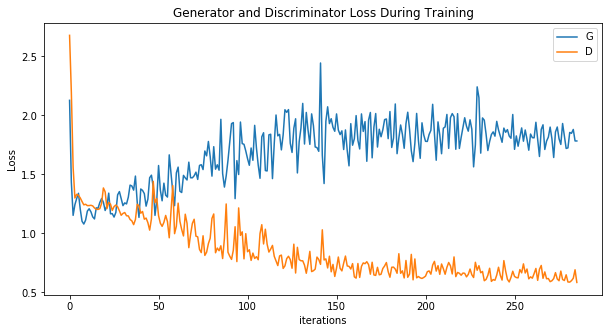

In [35]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g,label="G")
plt.plot(losses_d,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

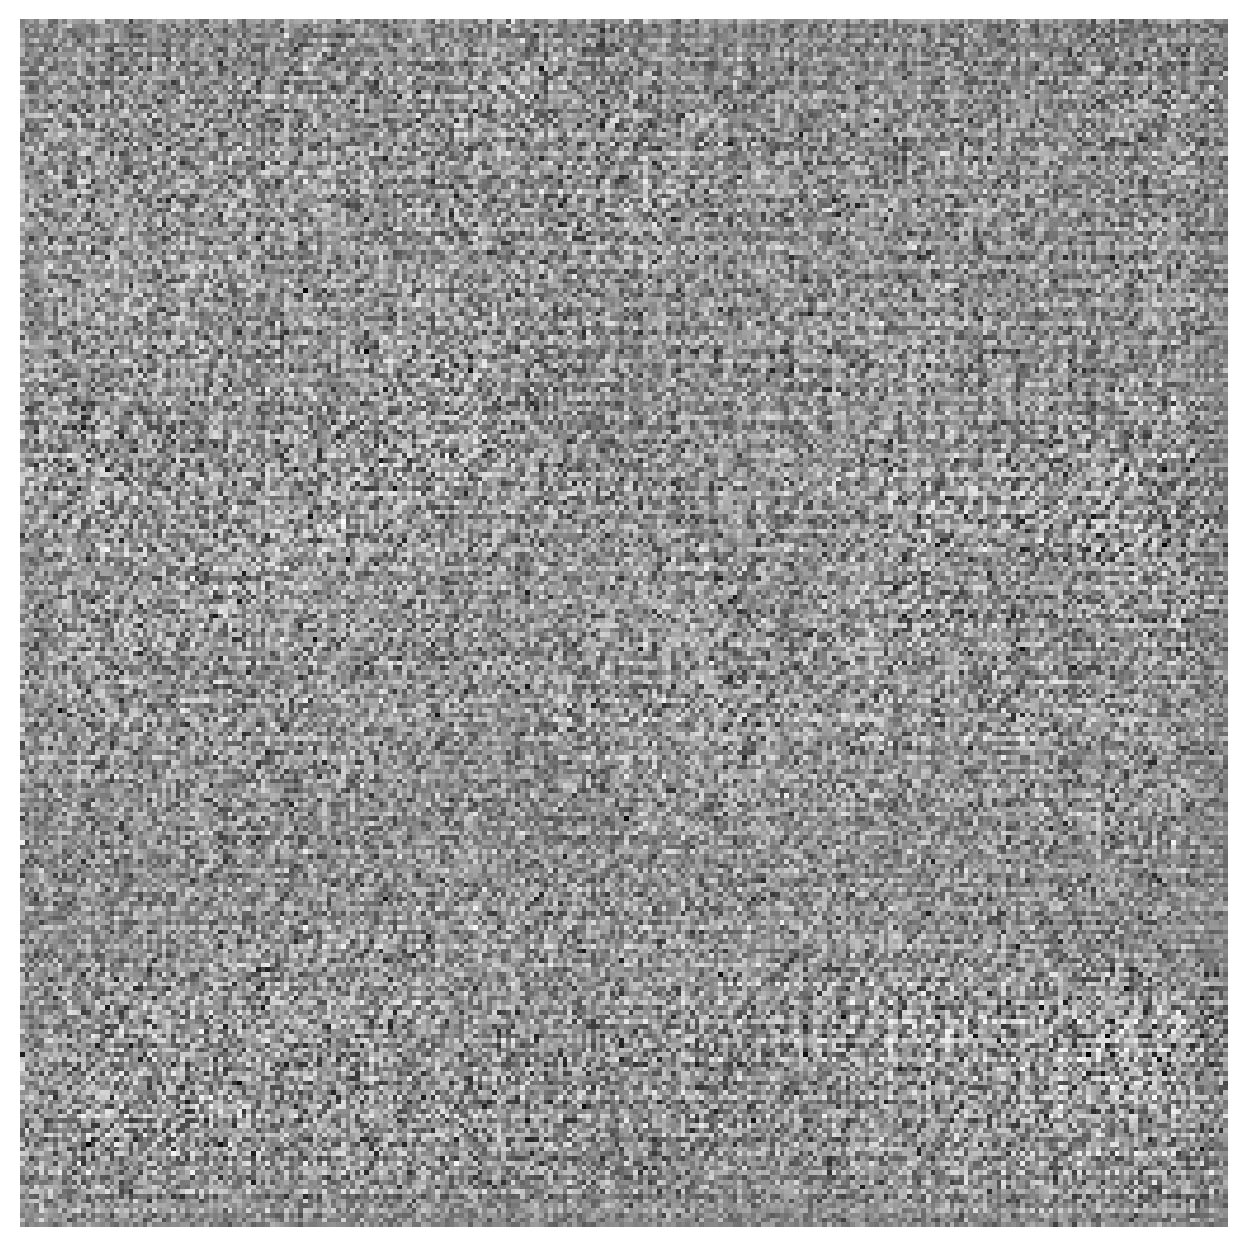

In [41]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in intermediate_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000/12, repeat_delay=1000/12, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()